In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def sessional_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * sessional_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

slope = 0.05
series = baseline + trend(time, slope) + \
    seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

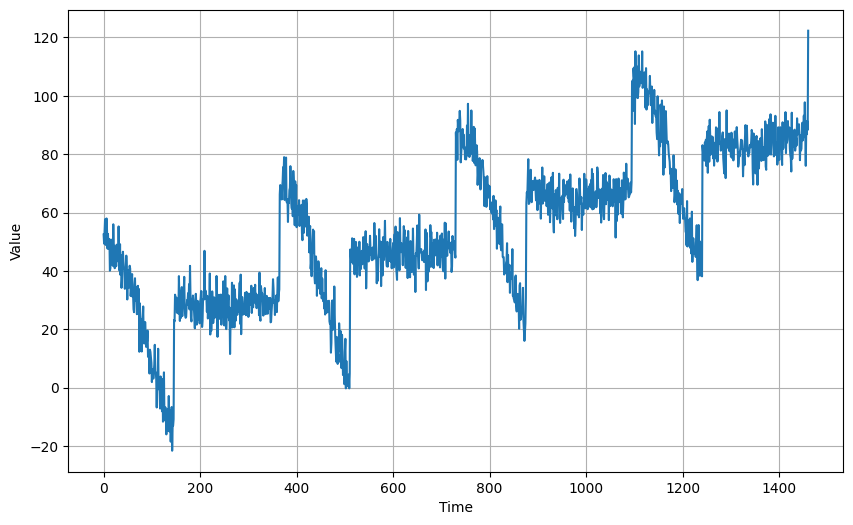

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
early_stopping = keras.callbacks.EarlyStopping(patience=10)
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100,
                    validation_data=valid_set,
                    callbacks=[lr_schedule, early_stopping])

Epoch 1/100



31/31 [==============================] - 3s 26ms/step - loss: 28.8259 - mae: 29.3225 - val_loss: 38.9160 - val_mae: 39.4160 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 16.6683 - mae: 17.1587 - val_loss: 14.8678 - val_mae: 15.3602 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 1s 12ms/step - loss: 11.6310 - mae: 12.1206 - val_loss: 10.7166 - val_mae: 11.2056 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 1s 12ms/step - loss: 11.3874 - mae: 11.8765 - val_loss: 10.6558 - val_mae: 11.1448 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 11.3005 - mae: 11.7893 - val_loss: 10.6919 - val_mae: 11.1801 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 1s 10ms/step - loss: 11.1922 - mae: 11.6811 - val_loss: 10.5709 - val_mae: 11.0580 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 1s 10ms/step - loss: 11.0828 - mae: 11.57

(1e-06, 0.001, 0.0, 20.0)

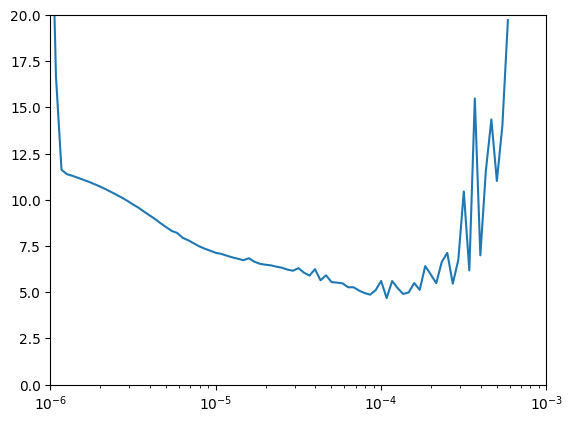

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [ ]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [9]:
lin_forecast.shape

NameError: name 'lin_forecast' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
early_stopping = keras.callbacks.EarlyStopping(patience=5)
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data=valid_set, callbacks=[
                    lr_schedule, early_stopping])

Epoch 1/100
31/31 [==============================] - 4s 74ms/step - loss: 40.3170 - mae: 40.8164 - val_loss: 72.6930 - val_mae: 73.1930 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 1s 15ms/step - loss: 39.9815 - mae: 40.4810 - val_loss: 72.0178 - val_mae: 72.5178 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 1s 13ms/step - loss: 39.5889 - mae: 40.0885 - val_loss: 71.3228 - val_mae: 71.8228 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 1s 12ms/step - loss: 39.1753 - mae: 39.6749 - val_loss: 70.5994 - val_mae: 71.0994 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 1s 10ms/step - loss: 38.7414 - mae: 39.2411 - val_loss: 69.8605 - val_mae: 70.3605 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 1s 10ms/step - loss: 38.2867 - mae: 38.7864 - val_loss: 69.1038 - val_mae: 69.6038 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 1s 10ms/step - loss: 37.8191 

In [11]:
dense_forecasting = model_forecast(
    model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 10ms/step


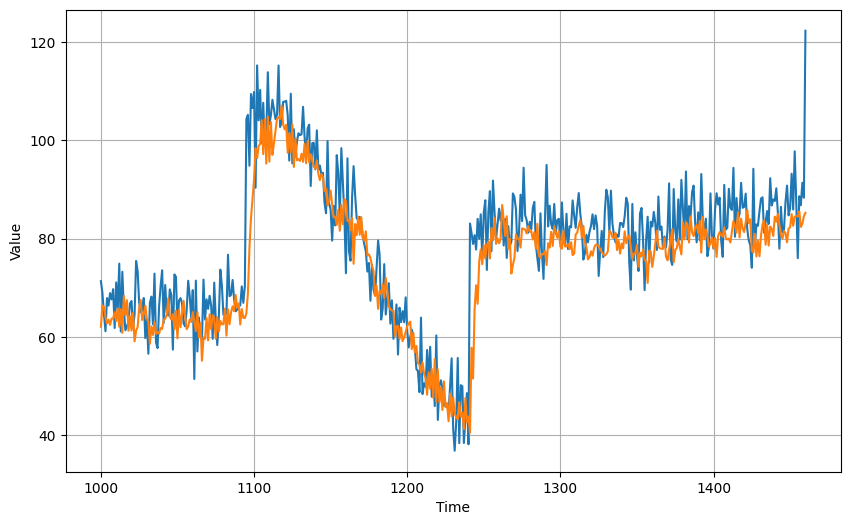

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecasting)

In [13]:
keras.metrics.mean_absolute_error(x_valid, dense_forecasting).numpy()

5.7903986